# HW1

Подключение библиотек, которыми воспользуемся для решения задачи

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDRegressor
from tqdm import tqdm

In [4]:
sample = pd.read_csv('./data/sample_submission.csv')
test = pd.read_csv('./data/test.csv')
train = pd.read_csv('./data/train.csv')

## Анализ train

Посмотрим что у нас в train

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Так как задача заключается в анализе цены методами линейной регрессии, то предположим из жизненного опыта, что есть линейная зависимость между ценой и площадью

Покажем это на графике

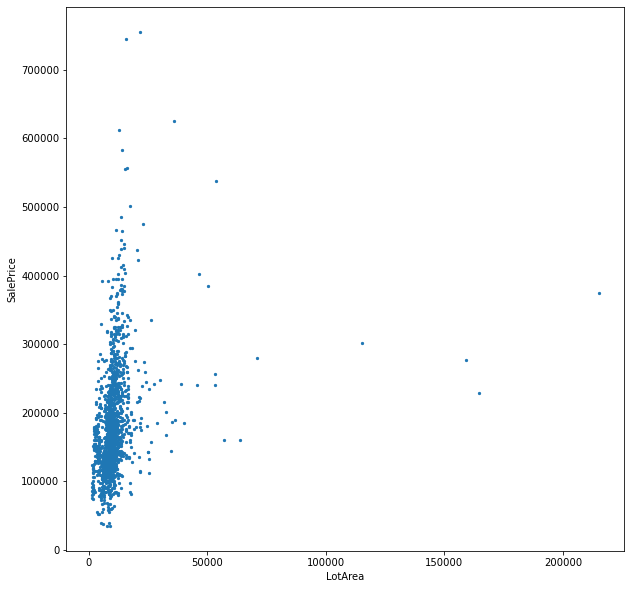

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter( train['LotArea'], train['SalePrice'] , s= 5)
plt.xlabel('LotArea')
plt.ylabel('SalePrice')
plt.show()

Из графика видно, что наше предположение верно, но нужно найти еще 1-2 переменные для модели, так как предсказание только на основе одной лишь площади могут быть не точными

На ценообразование влияет, также год постройки дома, давайте немного предобработаем данный столбец и посмотрим на зависимость цены от года постройки до и после 

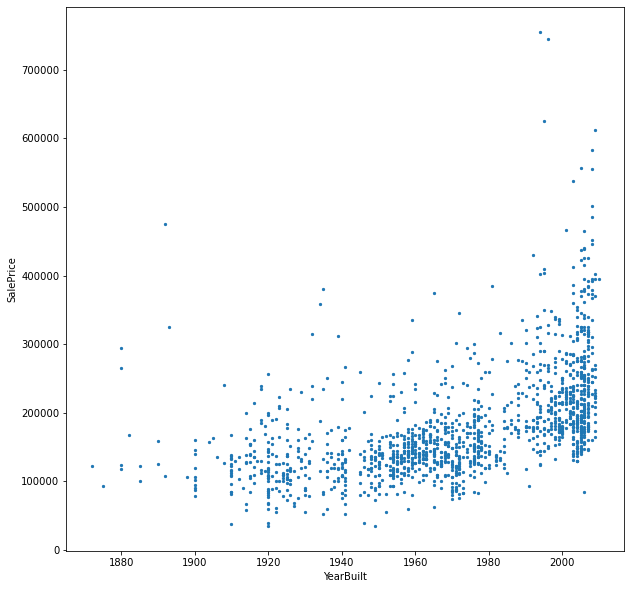

In [7]:
plt.figure(figsize=(10, 10))
plt.scatter( train['YearBuilt'], train['SalePrice'] , s= 5)
plt.xlabel('YearBuilt')
plt.ylabel('SalePrice')
plt.show()

In [8]:
YearBuilt_scaler =  MinMaxScaler()
train['YearBuiltNormalized'] = YearBuilt_scaler.fit_transform(train[['YearBuilt']])
test['YearBuiltNormalized'] = YearBuilt_scaler.transform(test[['YearBuilt']])

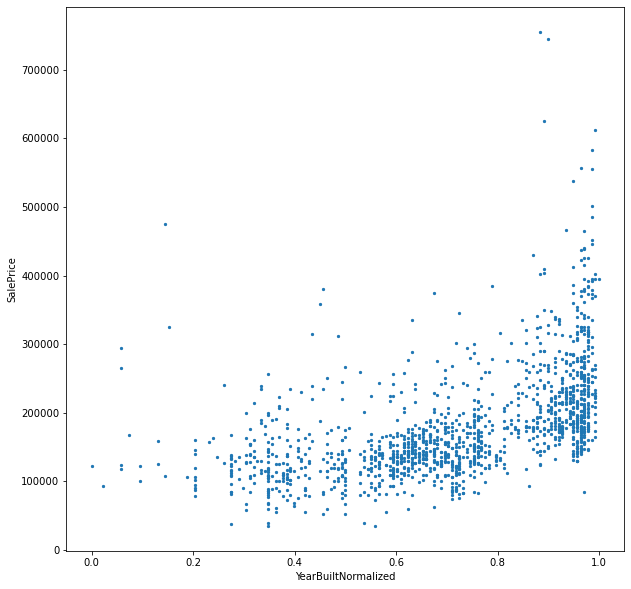

In [9]:
plt.figure(figsize=(10, 10))
plt.scatter( train['YearBuiltNormalized'], train['SalePrice'] , s= 5)
plt.xlabel('YearBuiltNormalized')
plt.ylabel('SalePrice')
plt.show()

Из обоих графиков видим, что зависимость экспонетциальная, то есть цена растет по экспоненте в зависимости от года постройки здания.

Также стоит отметить, что наша нормализация не привела к изменениям зависимости цены от года постройки, следовательно в дальнейшем будем пользоваться новым столбцом для обучения модели.

In [10]:
train['LogSalePrice'] = np.log1p(train['SalePrice'])

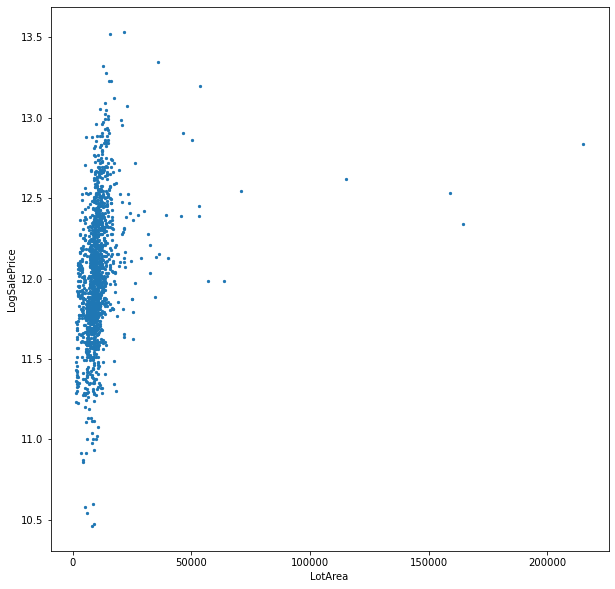

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter( train['LotArea'], train['LogSalePrice'] , s= 5)
plt.xlabel('LotArea')
plt.ylabel('LogSalePrice')
plt.show()

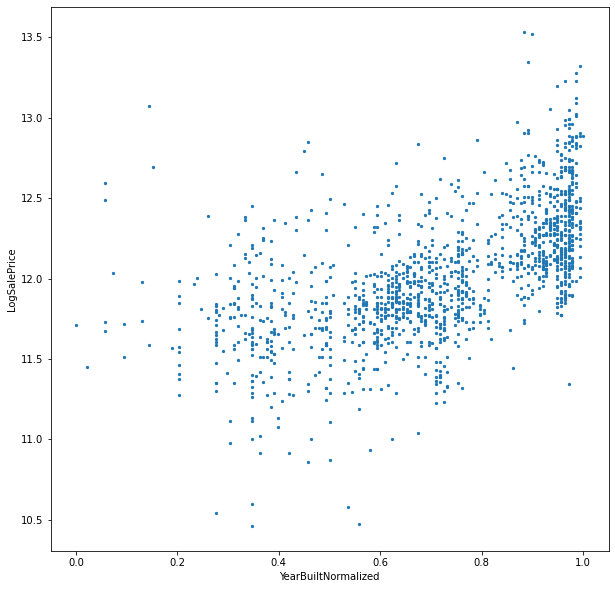

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter( train['YearBuiltNormalized'], train['LogSalePrice'] , s= 5)
plt.xlabel('YearBuiltNormalized')
plt.ylabel('LogSalePrice')
plt.show()

После логорифмирования цены, визуально график зависимости цены от площади не изменился, но из-за математических преположений логарифмируем и столбец данных с площадями.

In [13]:
train['LogLotArea'] = np.log1p(train['LotArea'])
test['LogLotArea'] = np.log1p(test['LotArea'])

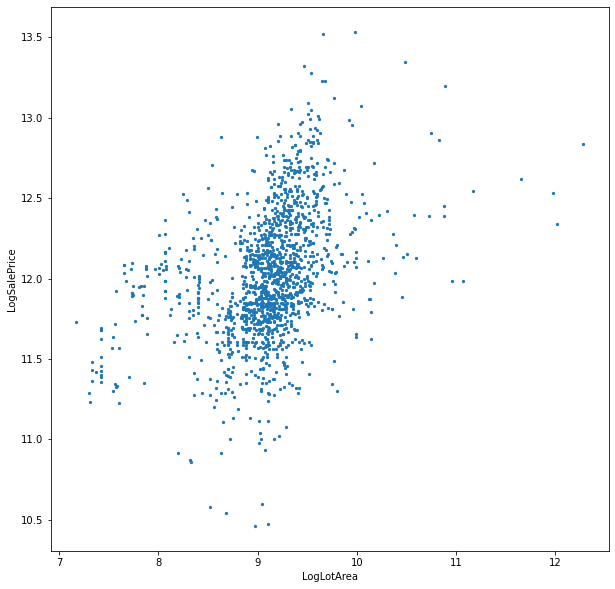

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter( train['LogLotArea'], train['LogSalePrice'] , s= 5)
plt.xlabel('LogLotArea')
plt.ylabel('LogSalePrice')
plt.show()

Предположительно, несмотря на большой разброс мы можем аппроксимировать эти данные прямой с какой-то погрешностью, и уменьшив диапозоны, мы увидели, что у нас будет погрешность

Приведем данные площади к стандартному для статистики виду, удалению среднего(mean = 0) и масштабированию до единичной дисперсии(sd = 1).

In [15]:
LogLotArea_scaler =  StandardScaler()
train['LogLotAreaNormalized'] = LogLotArea_scaler.fit_transform(train[['LogLotArea']])
test['LogLotAreaNormalized'] = LogLotArea_scaler.transform(test[['LogLotArea']])

Сравним распределения старого столбца и нового.

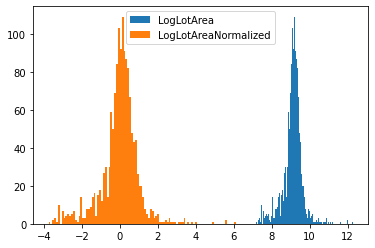

In [16]:
plt.hist(train['LogLotArea'] , bins= 100 , label='LogLotArea')
plt.hist(train['LogLotAreaNormalized'] , bins= 100 , label='LogLotAreaNormalized')
plt.legend()
plt.show()

Заметим, что есть небольшие выбросы, но будем надеятся, что они не повлияют на нашу модель серьезно.

Для решения поставленного задания, надо будет составить несколько моделей, для этого предположим, что местность в которой продается жилье, также влияет на цену линейно.

Посмотрим на это, но сначала, требуется привести столбец в виду чисел и произвести нормализацию данных

In [17]:
test['MSZoning'].value_counts(normalize=True)

RL         0.765636
RM         0.166323
FV         0.050859
C (all)    0.010309
RH         0.006873
Name: MSZoning, dtype: float64

In [18]:
train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [19]:
LE_MSZoning = LabelEncoder()
train['EncodedMSZoning'] = LE_MSZoning.fit_transform(train['MSZoning'])
test['EncodedMSZoning'] = LE_MSZoning.fit_transform(test['MSZoning'].astype(str))

In [20]:
MSZoning_scaler =  StandardScaler()
train['MSZoningNormalized'] = MSZoning_scaler.fit_transform(train[['EncodedMSZoning']])
test['MSZoningNormalized'] = MSZoning_scaler.transform(test[['EncodedMSZoning']])

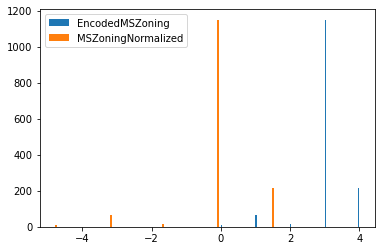

In [21]:
plt.hist(train['EncodedMSZoning'] , bins= 100 , label='EncodedMSZoning')
plt.hist(train['MSZoningNormalized'] , bins= 100 , label='MSZoningNormalized')
plt.legend()
plt.show()

## Построение модели


Для решения воспользуемся моделью SGDRegressor()



Будет происходить обучение для каждой модели.

Рассмотрим деление нашего тренировочного датасета на части, с помощью KFold(), и посчитаем ошибку вычисления для каждого разбиения и каждой модели. 

In [22]:
kf = KFold(n_splits=5)
rmse_error_list1 = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print( "Fold: ", i)
    X_train, X_test = train.loc[train_index, ['YearBuiltNormalized', 'LogLotAreaNormalized']],  train.loc[test_index, ['YearBuiltNormalized', 'LogLotAreaNormalized']]
    y_train, y_test = train.loc[train_index, 'LogSalePrice'], train.loc[test_index, 'LogSalePrice']
    
    model1 = SGDRegressor()
    model1.fit( X_train , y = y_train)
    fold_prediction = model1.predict( X =X_test ) 
    rmse_error = np.sqrt(mean_squared_error(y_test, fold_prediction))
   
    print('Error: ',rmse_error )

    rmse_error_list1.append(rmse_error)

Fold:  0
Error:  0.3282068888534507
Fold:  1
Error:  0.3399299377184632
Fold:  2
Error:  0.3400636876880667
Fold:  3
Error:  0.3111099318493596
Fold:  4
Error:  0.3689029559207867


In [23]:
kf = KFold(n_splits=5)
rmse_error_list2 = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print( "Fold: ", i)
    X_train, X_test = train.loc[train_index, [ 'LogLotAreaNormalized']],  train.loc[test_index, [ 'LogLotAreaNormalized']]
    y_train, y_test = train.loc[train_index, 'LogSalePrice'], train.loc[test_index, 'LogSalePrice']
    
    model2 = SGDRegressor()
    model2.fit( X_train , y = y_train)
    fold_prediction = model2.predict( X =X_test )
    
    # root mean squared error
#     rmse_error = np.sqrt( np.sum((y_test-fold_prediction)**2/ len(y_test)) )
    
    rmse_error = np.sqrt(mean_squared_error(y_test, fold_prediction))
   
    print('Error: ',rmse_error )

    rmse_error_list2.append(rmse_error)

Fold:  0
Error:  0.34553899101543817
Fold:  1
Error:  0.3876125659380028
Fold:  2
Error:  0.37418062030598803
Fold:  3
Error:  0.3650923649418588
Fold:  4
Error:  0.35911585575883825


In [24]:
kf = KFold(n_splits=5)
rmse_error_list3 = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print( "Fold: ", i)
    X_train, X_test = train.loc[train_index, [ 'YearBuiltNormalized']],  train.loc[test_index, [ 'YearBuiltNormalized']]
    y_train, y_test = train.loc[train_index, 'LogSalePrice'], train.loc[test_index, 'LogSalePrice']
    
    model3 = SGDRegressor()
    model3.fit( X_train , y = y_train)
    fold_prediction = model3.predict( X =X_test )
    
    
    rmse_error = np.sqrt(mean_squared_error(y_test, fold_prediction))
   
    print('Error: ',rmse_error )

    rmse_error_list3.append(rmse_error)

Fold:  0
Error:  0.36073926649026794
Fold:  1
Error:  0.3737051446223209
Fold:  2
Error:  0.38263063112420276
Fold:  3
Error:  0.34278502744943673
Fold:  4
Error:  0.3943276344097576


In [25]:
kf = KFold(n_splits=5)
rmse_error_list4 = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print( "Fold: ", i)
    X_train, X_test = train.loc[train_index, ['MSZoningNormalized', 'LogLotAreaNormalized']],  train.loc[test_index, ['MSZoningNormalized', 'LogLotAreaNormalized']]
    y_train, y_test = train.loc[train_index, 'LogSalePrice'], train.loc[test_index, 'LogSalePrice']
    
    model4 = SGDRegressor()
    model4.fit( X_train , y = y_train)
    fold_prediction = model4.predict( X =X_test )
    
    
    rmse_error = np.sqrt(mean_squared_error(y_test, fold_prediction))
   
    print('Error: ',rmse_error )

    rmse_error_list4.append(rmse_error)

    ['MSZoningNormalized', 'LogLotAreaNormalized']

Fold:  0
Error:  0.33871556717495865
Fold:  1
Error:  0.38460701533536407
Fold:  2
Error:  0.36607855550767293
Fold:  3
Error:  0.36080908186291594
Fold:  4
Error:  0.3550569669519576


In [26]:
kf = KFold(n_splits=5)
rmse_error_list5 = []

for i, (train_index, test_index) in enumerate(kf.split(train)):
    print( "Fold: ", i)
    X_train, X_test = train.loc[train_index, ['YearBuiltNormalized', 'MSZoningNormalized']],  train.loc[test_index, ['YearBuiltNormalized', 'MSZoningNormalized']]
    y_train, y_test = train.loc[train_index, 'LogSalePrice'], train.loc[test_index, 'LogSalePrice']
    
    model5 = SGDRegressor()
    model5.fit( X_train , y = y_train)
    fold_prediction = model5.predict( X =X_test ) 
    rmse_error = np.sqrt(mean_squared_error(y_test, fold_prediction))
   
    print('Error: ',rmse_error )

    rmse_error_list5.append(rmse_error)

Fold:  0
Error:  0.3707968807847518
Fold:  1
Error:  0.37863750211752645
Fold:  2
Error:  0.38776760222112644
Fold:  3
Error:  0.3472190675963986
Fold:  4
Error:  0.40331088713622565


Посмотрим среднюю ошибку для каждой модели

In [27]:
print('mean_cv_rmse_error для model1:', np.mean(rmse_error_list1))
print('mean_cv_rmse_error для model2:', np.mean(rmse_error_list2))
print('mean_cv_rmse_error для model3:', np.mean(rmse_error_list3))
print('mean_cv_rmse_error для model4:', np.mean(rmse_error_list4))
print('mean_cv_rmse_error для model5:', np.mean(rmse_error_list5))

mean_cv_rmse_error для model1: 0.33764268040602535
mean_cv_rmse_error для model2: 0.36630807959202527
mean_cv_rmse_error для model3: 0.3708375408191972
mean_cv_rmse_error для model4: 0.3610534373665738
mean_cv_rmse_error для model5: 0.3775463879712058


In [28]:
mean_cv_rmse_error1 = np.mean(rmse_error_list1)
mean_cv_rmse_error2 = np.mean(rmse_error_list2)
mean_cv_rmse_error3 = np.mean(rmse_error_list3)
mean_cv_rmse_error4 = np.mean(rmse_error_list4)
mean_cv_rmse_error5 = np.mean(rmse_error_list5)

In [29]:
model1.fit(train.loc[:, [ 'YearBuiltNormalized', 'LogLotAreaNormalized']],  
           train.loc[:,  'LogSalePrice'])
model2.fit(train.loc[:, [ 'LogLotAreaNormalized']],  
           train.loc[:,  'LogSalePrice'])
model3.fit(train.loc[:, [ 'YearBuiltNormalized']],  
           train.loc[:,  'LogSalePrice'])
model4.fit(train.loc[:, [ 'MSZoningNormalized', 'LogLotAreaNormalized']],  
           train.loc[:,  'LogSalePrice'])
model5.fit(train.loc[:, [ 'YearBuiltNormalized', 'MSZoningNormalized']],  
           train.loc[:,  'LogSalePrice'])


SGDRegressor()

In [30]:
predict1 =  model1.predict(test.loc[:, ['YearBuiltNormalized', 'LogLotAreaNormalized']])
predict2 =  model2.predict(test.loc[:, ['LogLotAreaNormalized']])
predict3 =  model3.predict(test.loc[:, ['YearBuiltNormalized']])
predict4 =  model4.predict(test.loc[:, ['MSZoningNormalized', 'LogLotAreaNormalized']])
predict5 =  model5.predict(test.loc[:, ['YearBuiltNormalized', 'MSZoningNormalized']])

Запишем наше итоговые предсказания цены для каждой из моделей.

In [31]:
sample1 = sample
sample1['SalePrice'] = np.expm1(predict1)
sample1.to_csv('submission1.csv', index = None)

In [32]:
sample2 = sample
sample2['SalePrice'] = np.expm1(predict2)
sample2.to_csv('submission2.csv', index = None)

In [33]:
sample3 = sample
sample3['SalePrice'] = np.expm1(predict3)
sample3.to_csv('submission3.csv', index = None)

In [34]:
sample4 = sample
sample4['SalePrice'] = np.expm1(predict4)
sample4.to_csv('submission4.csv', index = None)

In [35]:
sample5 = sample
sample5['SalePrice'] = np.expm1(predict5)
sample5.to_csv('submission5.csv', index = None)

После выгрузки всех результатов на kaggle, получили следующие результаты.

In [36]:
lb = [0.31958, 0.39096, 0.34396, 0.38189, 0.34786]

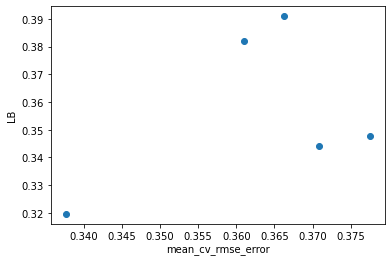

In [37]:
plt.scatter( [mean_cv_rmse_error1, mean_cv_rmse_error2, mean_cv_rmse_error3, mean_cv_rmse_error4, mean_cv_rmse_error5], lb)
plt.xlabel('mean_cv_rmse_error')
plt.ylabel('LB')
plt.show()

Из этого графика можно увидеть, что признак "Год постройки" дает погрешности в обучении, из-за чего метрика на kaggle просаживается, наиболее важный признак это площадь жилья, также хороший результат показал признак местности. Возможно стоит воспользоваться методами выделения наиболее влиящих признаков.